<br>Last Verified to Run: **2022-08-24**

<br>Software Versions:
  - `ts_wep`: **v2.5.4**
  - `lsst_distrib`: **w_2022_32**
  
## Goal
Take donut images from corner wavefront simulation including sky background. Vary the field information provided to the `ts_wep` `Algorithm.py`, and investigate how that affects the shape of donut masks, and Zernike estimation. Compare to the baseline (no offset).


## Setup
    
   * access to NCSA lsst-devl nodes 
   * working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) for additional info on how to install and build the AOS packages)
    
It is assumed that `$USER` is the username and `ts_wep` is installed in `$PATH_TO_TS_WEP`.

At least once after cloning the `ts_analysis_notebooks` repo one needs to run the `setup` and `scons` commands.

## Imports

In [3]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

In [2]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [3]:
def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog


def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId, 
                          collections=[collection])
    return postIsr



First, use high density simulations of corner sensors (no background). Preview the postISR images:

In [4]:
path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
dir_name = 'masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'
repo_dir  = os.path.join(path_to_project, dir_name)

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'
sensor = 'R00'

intraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

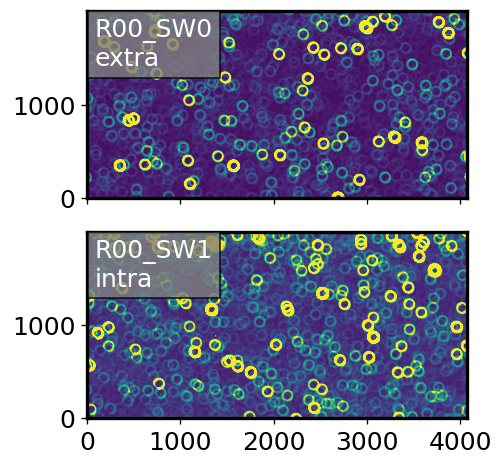

In [5]:

zscale = ZScaleInterval()

if sensor[1] == sensor[2]:
    ncols=1; nrows=2
else:
    ncols=2; nrows=1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4, 4), sharex=True, sharey=True, dpi=120)

# intra is more vignetted
if sensor[1] == "4":
    ax = ax[::-1]

# plot the extrafocal chip
i=0
for exposure, label in zip([extraImage, intraImage], ['extra','intra']):
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin,vmax=vmax,origin="lower")
    ax[i].text(0.02, 0.96, f"{ exposure.getInfo().getDetector().getName()}\n{label}", 
    transform=ax[i].transAxes, ha="left", va="top", c="w",fontsize=15,
             bbox=dict(facecolor='grey', alpha=0.8, edgecolor='black'))
    i=1


plt.tight_layout()
plt.show()

First, plot the donut stamps:

In [6]:
extraFocalStamps, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

intraFocalStamps, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

6 9


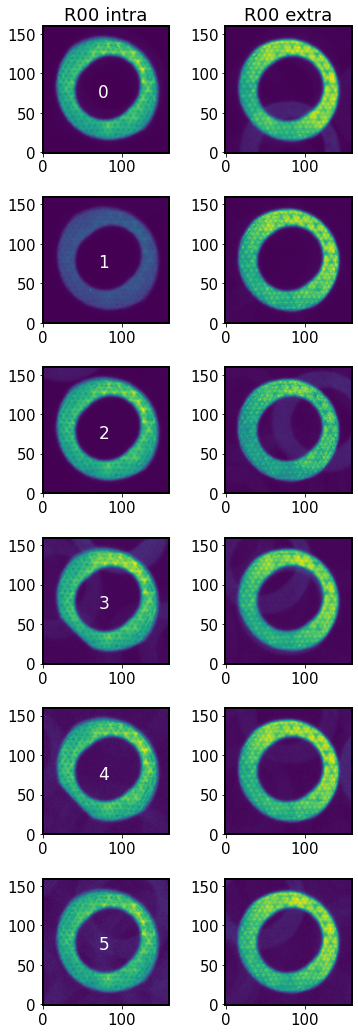

In [7]:
%matplotlib inline

nIntra = len(intraFocalStamps)
nExtra = len(extraFocalStamps)
print(nIntra,nExtra)
nDonuts = min(nIntra, nExtra)
ncols = 2
nrows = nDonuts

fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for i in range(nDonuts):
    ax[i,0].imshow(intraFocalStamps[i].stamp_im.image.array, origin='lower')
    ax[i,1].imshow(extraFocalStamps[i].stamp_im.image.array, origin='lower')
    ax[i,0].text(70,70, f'{i}', fontsize=17, c='white')
    
fig.subplots_adjust(hspace=0.35)  
ax[0,0].set_title(f'{sensor} intra')
ax[0,1].set_title(f'{sensor} extra')
#fig.suptitle(sensor, fontsize=20)
plt.savefig(f'{sensor}_donuts.png', bbox_inches='tight')

There are 6 intra-focal and 9 extra-focal donuts, but ts_wep at this point simply pairs the two donut lists side-by-side, so that extra donuts are not used. 

### Vary centroid in a grid 

Here we experiment with the information on the centroid position `fieldXY` stored in the compensable image. This is used to determine where the donut is on the focal plane, which implies the amount of vignetting in the mask, as well as the expected field location. 

First, we vary the centroid information exploring a rectangular grid of offsets spanning from -100 px to +100 px in both x and y away from the original donut position. The position of only one donut is updated at a time, i.e. either only intra-focal  or the extra-focal (with the other one having the original centroid position). 

In [19]:
def offset_centroid_square_grid(repo_dir ,
                                instrument = 'LSSTCam',
                                collection='ts_phosim_9006070',
                                sensors=['R00'],
                                index_increase='both', 
                                experiment_index = 1,
                                out_dir = 'DM-33104'):
    ''' Steps to vary centroid position in a rectangular grid 


    Parameters:
    --------------
    index_increase: str, 'both' increase the index of both extra and intra-focal donuts, 
    i.e. fit donutIntra[i] with donutExtra[i],
    'intra': increase only the index of intra-focal donuts, keeping the extra-focal 
    fixed, eg. pair donutIntra[i] with donutExtra[0]



    '''

    #################################
    ### STEP 1 :  Load the stamps
    #################################

    # iterate over all sensors
    for sensor in sensors: 

        print(f'Fitting {sensor}')
        donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,
                                              instrument=instrument, 
                                              iterN=0, detector=f"{sensor}_SW0",
                                              dataset_type = 'donutStampsExtra', 
                                              collection=collection)

        donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,
                                              instrument=instrument, 
                                              iterN=0, detector=f"{sensor}_SW1",
                                              dataset_type = 'donutStampsIntra', 
                                              collection=collection)

        extraImage = get_butler_image(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      collection=collection)
        # get the pixel scale from exposure to convert from pixels 
        # to arcsec to degrees
        pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


        configDir = getConfigDir()
        instDir = os.path.join(configDir, "cwfs", "instData")
        algoDir = os.path.join(configDir, "cwfs", "algo")

        # now I follow parts of 
        # wfEsti = WfEstimator(instDir, algoDir)
        inst = Instrument(instDir)
        algo = Algorithm(algoDir)

        # now I get the camera type and defocal distance
        # as inside estimateZernikes()
        # instName gets specified in the config,
        # and does not get overridden for CWFS
        instName='lsst'    
        camType = getCamType(instName)
        defocalDisInMm = getDefocalDisInMm(instName)

        # now I follow parts of 
        # wfEsti.config
        opticalModel = 'offAxis'
        sizeInPix = 160
        inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

        # choose the solver for the algorithm 
        solver = 'exp' # or fft 
        debugLevel=0  # 1 to 3 
        algo.config(solver, inst, debugLevel=debugLevel)

        centroidFindType = CentroidFindType.RandomWalk
        imgIntra = CompensableImage(centroidFindType=centroidFindType)
        imgExtra = CompensableImage(centroidFindType=centroidFindType)

        #######################################
        ### STEP 2 :  Loop over donut pairs 
        #######################################

        if index_increase == 'both':
            irange = min(len(donutStampsExtra),len(donutStampsIntra))
        elif index_increase == 'intra':
            irange = len(donutStampsIntra)

        for i in irange: 
            if index_increase == 'both':
                i_in = i
                i_ex = i
                donutExtra = donutStampsExtra[i_ex]
                donutIntra = donutStampsIntra[i_in]
            elif index_increase == 'intra':
                i_in = i
                i_ex = 0
                donutExtra = donutStampsExtra[i_ex]
                donutIntra = donutStampsIntra[i_in]

            print(f'\n Fitting sensor {sensor}, donutIntra {i_in} with donutExtra {i_ex} ')
            
            # obtain the original fieldXY position attached to each donut stamp 
            fieldXYExtra = donutExtra.calcFieldXY()
            fieldXYIntra = donutIntra.calcFieldXY()

            #######################################
            ### STEP 2 A : fit baseline (no offset)
            #######################################

            camera = donutExtra.getCamera()
            detectorExtra = camera.get(donutExtra.detector_name)
            detectorIntra = camera.get(donutIntra.detector_name)

            # Rotate any sensors that are not lined up with the focal plane.
            eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
            eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

            # Now parts of wfEsti.setImg, which inherits .setImg 
            # method from CompensableImage
            imgExtra.setImg(fieldXYExtra,
                            DefocalType.Extra,
                            image=rotate(donutExtra.stamp_im.getImage().getArray(), 
                                eulerZExtra).T)

            imgIntra.setImg(fieldXYIntra,
                            DefocalType.Intra,
                            image=rotate(donutIntra.stamp_im.getImage().getArray(), 
                                eulerZIntra).T)

            # wfEsti.reset() inherits the .reset method of Algorithm.py: 
            algo.reset()

            # wfEsti.calWfsErr() after checking for image size 
            # (both need to be squares)
            # calls the Algorithm.py
            tol = 1e-3 # explicitly set the tolerance level
            algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
            zk_no_offset = algo.getZer4UpInNm()
            
            # store the compensable image, as well as the zernikes
            baseline = {}
            baseline['imgIntra'] = imgIntra
            baseline['imgExtra'] = imgExtra
            baseline['zks'] = zk_no_offset
            
            fname = f'exp-{experiment_index}_{sensor}_baseline_extra_{i_ex}_intra_{i_in}.npy'
            fpath = os.path.join(out_dir, fname)
            np.save(fpath, baseline)
            print(f'\nSaved the baseline fit as {fpath}')
            

            #######################################
            ### STEP 2 B : fit grid of dx, dy offset 
            #######################################

            ## First applying change to the extra-focal mask, and then to the intra-focal mask
            for defocal in ['intra','extra']: # or extra 
                print(f'Fitting {sensor} donuts {i_in} {i_ex} shifting {defocal} centroid ')
                zk0 = zk_no_offset

                dxInPixels = np.linspace(-100,100,20)
                dyInPixels = dxInPixels

                dxInDegrees = (dxInPixels* pixelScale) / 3600
                dyInDegrees = (dyInPixels* pixelScale) / 3600

                results = {}
                j =0 
                
                for dxDeg in dxInDegrees:
                    for dyDeg in dyInDegrees:
                        
                        # calculate radial offset
                        radialOffsetDegrees = np.sqrt(dxDeg**2.0+dyDeg**2.0)

                        # convert the x,y offset of the mask from degrees to pixels via pixelScale
                        radialOffsetPixels = ( radialOffsetDegrees * 3600 )/pixelScale

                        dxPx = (dxDeg * 3600) / pixelScale
                        dyPx = (dyDeg * 3600) / pixelScale
                        
                        results[j] = {'dxDeg':dxDeg, 'dyDeg':dyDeg, 
                                      'dxPx':dxPx, 'dyPx':dyPx, 
                                      'drDeg':radialOffsetDegrees,
                                      'drPx':radialOffsetPixels, 
                                      }

                         # do the fit 
                        if defocal == 'extra':
                            fieldXYExtraUpd = (fieldXYExtra[0]+dxDeg, fieldXYExtra[1]+dyDeg)
                            fieldXYIntraUpd = fieldXYIntra

                        elif defocal =='intra':
                            fieldXYExtraUpd = fieldXYExtra
                            fieldXYIntraUpd = (fieldXYIntra[0]+dxDeg, fieldXYIntra[1]+dyDeg)

                        imgExtra.setImg(fieldXYExtraUpd,
                                        DefocalType.Extra,
                                        image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

                        imgIntra.setImg(fieldXYIntraUpd,
                                        DefocalType.Intra,
                                        image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

                        # right after we set the image, the compensable image mask is empty - 
                        # it is only calculated in Algorithm.py, L694
                        maskScalingFactorLocal = 1
                        boundaryT = algo.getBoundaryThickness()
                        imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
                        imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

                        # now wfEsti.reset() calls the .reset() method of Algorithm.py : 
                        algo.reset()

                        # wfEsti.calWfsErr() after checking for image size (both need to be squares)
                        # simply calls algo:
                        tol = 1e-3 # explicitly set the tolerance level ( this is default )
                        algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)
                        zk = algo.getZer4UpInNm()
                        
                        # calculate diffMax, diffRms
                        diffMax = np.max(np.abs(zk - zk0))
                        diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))

                        # store the results 
                        results[j]['diffMax'] = diffMax
                        results[j]['diffRms'] = diffRms
                        results[j]['zk'] = zk
                        results[j]['imgExtraFieldXY'] = imgExtra.getFieldXY()
                        results[j]['imgIntraFieldXY'] = imgIntra.getFieldXY()

                        # increase the grid counter 
                        j += 1 
                        print(j, dxPx, dyPx, diffRms, )
                fname = f'exp-{experiment_index}_{sensor}_square_grid_extra_{i_ex}_intra_{i_in}.npy'
                fpath = os.path.join(out_dir, fname)
                np.save(fpath, results)
                print(f"saved {fname}")


In [ ]:
# run the fitting 
repo_name = 'masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
offset_centroid_square_grid(repo_name, collection='ts_phosim_9006070', 
                            index_increase='both',
                            experiment_index=1
                           )

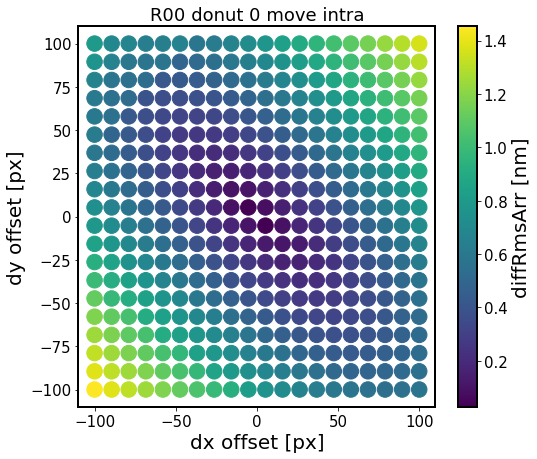

In [9]:
# read the data
sensor = 'R00'
defocal = 'intra'
i=0
fname = f'{sensor}_donut_{i}_{defocal}_offset_square_grid.npy'
fpath = os.path.join(path_to_project, 'AOS', fname)
results = np.load(fpath, allow_pickle=True).item()

# convert to continuous arrays
diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPxArr.append(results[j]['dxPx'])
    dyPxArr.append(results[j]['dyPx'])
    diffMaxArr.append(results[j]['diffMax'])
    diffRmsArr.append(results[j]['diffRms'])

    

fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(np.array(dxPxArr), np.array(dyPxArr), c=diffRmsArr, s=240)
#ax.hexbin(dxPxArr,dyPxArr,C=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}')
plt.colorbar(sc, label = 'diffRmsArr [nm]')

This shows that there is a structure to  RMS difference between offset centroid and the baseline Zernike fit. The RMS difference has a larger gradient in the direction towards/away from the focal plane, which corresponds to smaller/larger degree of vignetting.

## Vary centroid in a circle 

Here instead of evaluating the RMS difference on a square grid surrounding the initial position of the donut, we investigate how far away from the donut center can we move the centroid before the RMS difference is larger than 1 nanometer (which is a negligible difference, i.e. a very low threshold).

In [10]:
def offset_centroid_circle(repo_dir ,
                           instrument = 'LSSTCam',
                           collection='ts_phosim_9006070',
                           sensors=['R00'],
                           index_increase='both', 
                           experiment_index = 2,
                           out_dir = 'DM-33104'
                           ):
    ''' Steps to vary centroid position radially until  a diffRms 
        threshold is reached 


    Parameters:
    --------------
    index_increase: str, 'both' increase the index of both extra and intra-focal donuts, 
    i.e. fit donutIntra[i] with donutExtra[i],
    'intra': increase only the index of intra-focal donuts, keeping the extra-focal 
    fixed, eg. pair donutIntra[i] with donutExtra[0]



    '''

    #################################
    ### STEP 1 :  Load the stamps
    #################################

    # iterate over all sensors
    for sensor in sensors: 

        print(f'Fitting {sensor}')
        donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,
                                              instrument=instrument, 
                                              iterN=0, detector=f"{sensor}_SW0",
                                              dataset_type = 'donutStampsExtra', 
                                              collection=collection)

        donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,
                                              instrument=instrument, 
                                              iterN=0, detector=f"{sensor}_SW1",
                                              dataset_type = 'donutStampsIntra', 
                                              collection=collection)

        extraImage = get_butler_image(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      collection=collection)
        # get the pixel scale from exposure to convert from pixels 
        # to arcsec to degrees
        pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


        configDir = getConfigDir()
        instDir = os.path.join(configDir, "cwfs", "instData")
        algoDir = os.path.join(configDir, "cwfs", "algo")

        # now I follow parts of 
        # wfEsti = WfEstimator(instDir, algoDir)
        inst = Instrument(instDir)
        algo = Algorithm(algoDir)

        # now I get the camera type and defocal distance
        # as inside estimateZernikes()
        # instName gets specified in the config,
        # and does not get overridden for CWFS
        instName='lsst'    
        camType = getCamType(instName)
        defocalDisInMm = getDefocalDisInMm(instName)

        # now I follow parts of 
        # wfEsti.config
        opticalModel = 'offAxis'
        sizeInPix = 160
        inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

        # choose the solver for the algorithm 
        solver = 'exp' # or fft 
        debugLevel=0  # 1 to 3 
        algo.config(solver, inst, debugLevel=debugLevel)

        centroidFindType = CentroidFindType.RandomWalk
        imgIntra = CompensableImage(centroidFindType=centroidFindType)
        imgExtra = CompensableImage(centroidFindType=centroidFindType)

        #######################################
        ### STEP 2 :  Loop over donut pairs 
        #######################################

        if index_increase == 'both':
            irange = min(len(donutStampsExtra),len(donutStampsIntra))
        elif index_increase == 'intra':
            irange = len(donutStampsIntra)

        for i in irange: 
            if index_increase == 'both':
                i_in = i
                i_ex = i
                donutExtra = donutStampsExtra[i_ex]
                donutIntra = donutStampsIntra[i_in]
            elif index_increase == 'intra':
                i_in = i
                i_ex = 0
                donutExtra = donutStampsExtra[i_ex]
                donutIntra = donutStampsIntra[i_in]

            print(f'\n Fitting sensor {sensor}, donutIntra {i_in} with donutExtra {i_ex} ')
            
            # obtain the original fieldXY position attached to each donut stamp 
            fieldXYExtra = donutExtra.calcFieldXY()
            fieldXYIntra = donutIntra.calcFieldXY()

            #######################################
            ### STEP 2 A : fit baseline (no offset)
            #######################################

            camera = donutExtra.getCamera()
            detectorExtra = camera.get(donutExtra.detector_name)
            detectorIntra = camera.get(donutIntra.detector_name)

            # Rotate any sensors that are not lined up with the focal plane.
            eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
            eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

            # Now parts of wfEsti.setImg, which inherits .setImg 
            # method from CompensableImage
            imgExtra.setImg(fieldXYExtra,
                            DefocalType.Extra,
                            image=rotate(donutExtra.stamp_im.getImage().getArray(), 
                                eulerZExtra).T)

            imgIntra.setImg(fieldXYIntra,
                            DefocalType.Intra,
                            image=rotate(donutIntra.stamp_im.getImage().getArray(), 
                                eulerZIntra).T)

            # wfEsti.reset() inherits the .reset method of Algorithm.py: 
            algo.reset()

            # wfEsti.calWfsErr() after checking for image size 
            # (both need to be squares)
            # calls the Algorithm.py
            tol = 1e-3 # explicitly set the tolerance level
            algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
            zk_no_offset = algo.getZer4UpInNm()
            
            # store the compensable image, as well as the zernikes
            baseline = {}
            baseline['imgIntra'] = imgIntra
            baseline['imgExtra'] = imgExtra
            baseline['zks'] = zk_no_offset
            
            fname = f'exp-{experiment_index}_{sensor}_baseline_extra_{i_ex}_intra_{i_in}.npy'
            fpath = os.path.join(out_dir, fname)
            np.save(fpath, baseline)
            print(f'\nSaved the baseline fit as {fname}')
            

            #######################################
            ### STEP 2 B : fit grid of dx, dy offset 
            #######################################

            ## First applying change to the extra-focal mask, and then to the intra-focal mask
            for defocal in ['intra','extra']: # or extra 
                print(f'Fitting {sensor} donuts {i_in} {i_ex} shifting {defocal} centroid ')
                zk0 = zk_no_offset

                # starting boundary conditions 
                thetaRad = 0 # radians
                dthetaRad = 0.2 # radians ~ 11.45 deg 
                drPxStep = 10 # pixels 
                diffRmsThresh = 1.0 # nm 

                results = {}

                j=0
                # iterate over a range of angles 
                for thetaRad in np.arange(0,2*np.pi, dthetaRad):

                    # always start from 0 radius ... 
                    drPx = 0 # px 
                    diffRms = 0 # nm 

                    # increase radius until threshold is reached 
                    while diffRms < diffRmsThresh:

                        dxPx = drPx*np.cos(thetaRad)
                        dyPx = drPx*np.sin(thetaRad)

                        dxDeg = (dxPx * pixelScale) / 3600.
                        dyDeg = (dyPx * pixelScale) / 3600.

                        results[j]={'dxPx':dxPx, 'dyPx':dyPx, 'dxDeg':dxDeg, 'dyDeg':dyDeg,
                                    'drPx':drPx, }

                         # do the fit 
                        if defocal == 'extra':
                            fieldXYExtraUpd = (fieldXYExtra[0]+dxDeg, 
                                               fieldXYExtra[1]+dyDeg)
                            fieldXYIntraUpd = fieldXYIntra

                        elif defocal =='intra':
                            fieldXYExtraUpd = fieldXYExtra
                            fieldXYIntraUpd = (fieldXYIntra[0]+dxDeg, 
                                               fieldXYIntra[1]+dyDeg)

                        imgExtra.setImg(fieldXYExtraUpd,
                                        DefocalType.Extra,
                                        image=rotate(donutExtra.stamp_im.getImage().getArray(), 
                                                     eulerZExtra).T)

                        imgIntra.setImg(fieldXYIntraUpd,
                                        DefocalType.Intra,
                                        image=rotate(donutIntra.stamp_im.getImage().getArray(), 
                                                     eulerZIntra).T)

                        # right after we set the image, the compensable image mask is empty - 
                        # it is only calculated in Algorithm.py, L694
                        maskScalingFactorLocal = 1
                        boundaryT = algo.getBoundaryThickness()
                        imgIntra.makeMask(inst, opticalModel, boundaryT, 
                                          maskScalingFactorLocal)
                        imgExtra.makeMask(inst, opticalModel, boundaryT, 
                                          maskScalingFactorLocal)

                        # now wfEsti.reset() calls the .reset() method of Algorithm.py : 
                        algo.reset()

                        # wfEsti.calWfsErr() after checking for image size (both need to be squares)
                        # simply calls algo:
                        tol = 1e-3 # explicitly set the tolerance level ( this is default )
                        algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)
                        zk = algo.getZer4UpInNm()
                        
                        # calculate diffMax, diffRms
                        diffMax = np.max(np.abs(zk - zk0))
                        diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))

                        # store the results 
                        results[j]['diffMax'] = diffMax
                        results[j]['diffRms'] = diffRms
                        results[j]['zk'] = zk
                        results[j]['imgExtraFieldXY'] = imgExtra.getFieldXY()
                        results[j]['imgIntraFieldXY'] = imgIntra.getFieldXY()
                        
                        # increase the grid counter 
                        j += 1 
                    print(j-1, drPx, thetaRad, diffRms) 
                    print('Threshold reached at radius ', drPx)  
                # save the results
                fname = f'exp-{experiment_index}_{sensor}_circle_extra_{i_ex}_intra_{i_in}.npy'
                fpath = os.path.join(out_dir, fname)
                print(f"saved {fpath}")
                np.save(fpath, results)
            


In [ ]:
# run the fitting
offset_centroid_circle(repo_dir ,
    instrument = 'LSSTCam',
    collection='ts_phosim_9006070',
    sensors=['R00'],
    index_increase='both', 
    experiment_index = 2)

Plot the results

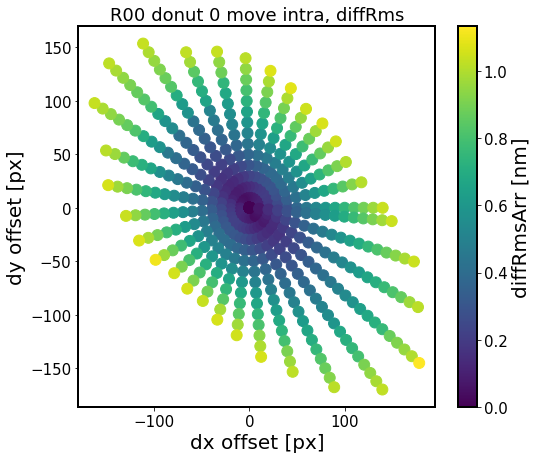

In [11]:
sensor = 'R00'
i = 0
defocal = 'intra'
fname = f'{sensor}_donut_{i}_{defocal}_offset_results_circle.npy'
fpath = os.path.join(path_to_project, 'AOS', fname)
results = np.load(fpath, allow_pickle=True).item()

diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPx = results[j]['dxPx']
    dyPx = results[j]['dyPx'] 
    
    dxPxArr.append(dxPx)
    dyPxArr.append(dyPx)

    # calculate max difference and rms difference 
    # just like in test_multImgs.py for ts_wep 
    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)
    
    
    
fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr, s=120)
#ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
plt.colorbar(sc, label = 'diffRmsArr [nm]')

This shows that we can move over 100 pixels in almost any direction (further away along the tangential direction vs radial). This means that the AOS algorithm is robust to such centroid offsets, i.e. the  computed mask does not change its shape enough to affect the result by more than 1 nm RMS in comparison to the baseline (no offset) calculation. 

Next we overplot the radius at which the 1 nm threshold has been reached on top of the donut stamp for size comparison: 

Text(0.5, 1.0, 'R00 donut 0 move intra, diffRms')

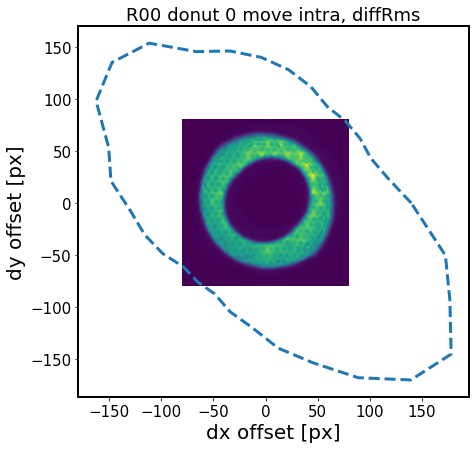

In [15]:
instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,
                                                        instrument=instrument, 
                                                        iterN=0, 
                                                        detector=f"{sensor}_SW0",
                                                        dataset_type = 'donutStampsExtra', 
                                                        collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)


imgExtra = donutStampsExtra[i]
imgIntra = donutStampsIntra[i]

imgArray = imgIntra.stamp_im.image.array

jrange = list(results.keys())
dxPxLastArr = []
dyPxLastArr = []
diffRmsLastArr = []
for j in jrange[1:]:
    if results[j]['drPx'] == 0:
        dxPxLastArr.append(results[j-1]['dxPx'])
        dyPxLastArr.append(results[j-1]['dyPx'])
        diffRmsLastArr.append(results[j-1]['diffRms'])
        
fig,ax = plt.subplots(1,1,figsize=(7,7))
dxNew = np.resize(dxPxLastArr,len(dxPxLastArr)+1)
dyNew = np.resize(dyPxLastArr,len(dyPxLastArr)+1)

# https://moonbooks.org/Articles/How-to-change-imshow-axis-values-labels-in-matplotlib-/
half = np.shape(imgArray)[0]/2.
x_min = -half
x_max = half
y_min = x_min
y_max = x_max
extent = [x_min , x_max, y_min , y_max]
ax.imshow(imgArray, origin='lower',extent = extent)
ax.plot(dxNew,dyNew,ls='--',lw=3)
N=0

#ax.scatter(dxPxLastArr[N], dyPxLastArr[N])
#ax.scatter(dxPxArr,dyPxArr,c=diffRmsLastArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')


Having calculated circle of RMS difference for multiple donuts, we plot these in the focal plane coordinates to summarize the results for all sensors. We employ the following steps:


* Read the donut postage stamp (intra, extra)
* Read the results of calculation for a given donut (moving intra, moving extra). 
* Convert the results from dic to array in donut coords
* Read out the final radius  so that we have an outline 
* Convert to detector coords
* Convert to field angle coords

* Plot the donut location and the outline of how far can we  move that donut location (fieldXY) passed to the algorithm before the diffRms calculated against the baseline (no offset) is greater than 1 nm (i.e. still barely detectable)



In [73]:
# Load the stamps
instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

def extract_max_radius(results):
    dxPxLastArr = []
    dyPxLastArr = []
    diffRmsLastArr = []
    jrange = list(results.keys())
    for j in jrange[1:]:
        #print(results[j]['drPx'])
        if results[j]['drPx'] == 0:
            #print(results[j-1]['dxPx'], results[j-1]['dyPx'], results[j-1]['diffRms'])
            dxPxLastArr.append(results[j-1]['dxPx'])
            dyPxLastArr.append(results[j-1]['dyPx'])
            diffRmsLastArr.append(results[j-1]['diffRms'])
    return  dxPxLastArr, dyPxLastArr, diffRmsLastArr

# iterate over all sensors
summary = {}

#for sensor in ['R00','R40','R44','R04']: 
for sensor in ['R04']:    
# choose R00 or R44
#sensor = 'R00'
    

    #print(f'Fitting {sensor}')
    donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)


    # iterate over all donuts 
    for i in range(3):#i = 0 
    #i = 0
    #for donutIntra, donutExtra in zip(donutStampsIntra, donutStampsExtra):
        
        donutIntra = donutStampsIntra[i]
        donutExtra = donutStampsExtra[i]

        # need to zip because there's different transform for intra 
        # and extra-focal detector 
        for defocal, donut in zip(['extra','intra'], [donutExtra, donutIntra]):
            key = f'{sensor}_{i}_{defocal}'
            summary[key] = {}

            fname = f'{sensor}_donut_{i}_{defocal}_offset_results_circle.npy'
            results = np.load(fname, allow_pickle=True).item()

            # extract the zone reached when diffRms >= 1 nm 
            dxPxLastArr, dyPxLastArr, diffRmsLastArr = extract_max_radius(results)

            # resize to plot an outline by rolling +1 
            dxNew = np.resize(dxPxLastArr,len(dxPxLastArr)+1)
            dyNew = np.resize(dyPxLastArr,len(dyPxLastArr)+1)


            summary[key]['dxOutline'] = dxNew
            summary[key]['dyOutline'] = dyNew


            # transform from donut coords to field angle coords 

            # first, get the camera and detector 

            camera = donut.getCamera()
            detector = camera.get(donut.detector_name)

            # to position in focal plane in radians
            transform = detector.getTransform(PIXELS, FIELD_ANGLE) 
            zero = transform.applyForward(Point2D(0, 0))
            xhat = transform.applyForward(Point2D(4000, 0))
            yhat = transform.applyForward(Point2D(0, 2000))


            centroid = donut.centroid_position
            centroidFieldAngle = transform.applyForward(centroid)

            # transform outline from donut px coords (via centroid) 
            # to detector px coords (via transform) to field coords
            ys = dxNew+centroid.y # treat x as y due to transpose done by ts_wep
            xs = dyNew+centroid.x

            fps = [Point2D(fpx_, fpy_) for fpx_, fpy_ in zip(xs, ys)]

            pixels = transform.applyForward(fps)

            # this is now in field angle coords, i.e. radians 
            fpx = [pixel.x for pixel in pixels]
            fpy = [pixel.y for pixel in pixels]


            # finally get detector center in field angle coord
            center = detector.getCenter(FIELD_ANGLE)

            summary[key]['dxOutlineRad'] = fpx
            summary[key]['dyOutlineRad'] = fpy
            summary[key]['centroidDetector'] = centroid
            summary[key]['centroidFieldAngle'] = centroidFieldAngle
            summary[key]['zeroFieldAngle'] = zero
            summary[key]['xHatFieldAngle'] = xhat
            summary[key]['yHatFieldAngle'] = yhat
            summary[key]['detectorCenterFieldAngle'] = center
            summary[key]['detectorName'] = detector.getName()
        # increase donut count 
        #i += 1 

R04_0_extra 583.0 945.0
R04_0_intra 2288.0 303.0
R04_1_extra 3098.0 996.0
R04_1_intra 911.0 1630.0
R04_2_extra 3407.0 398.0
R04_2_intra 697.0 790.0


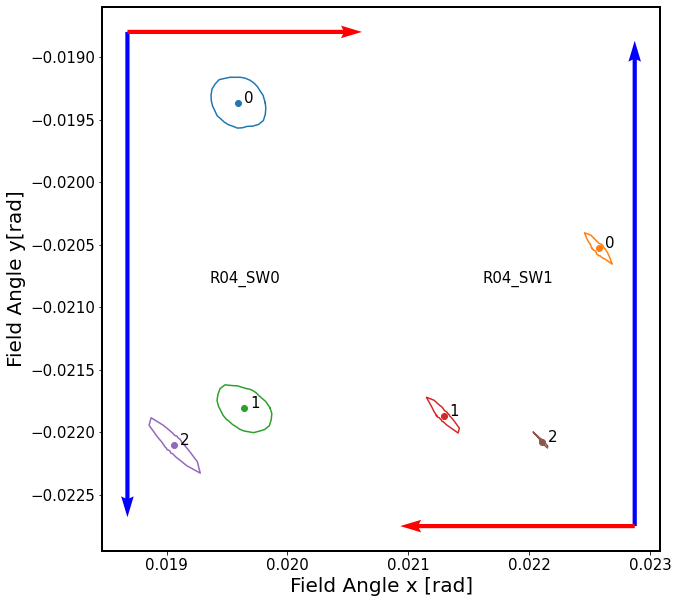

In [74]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

detectors_plotted = []
for key in summary.keys():
    xhat = summary[key]['xHatFieldAngle']
    yhat = summary[key]['yHatFieldAngle']
    zero = summary[key]['zeroFieldAngle']
    fpx = summary[key]['dxOutlineRad']
    fpy = summary[key]['dyOutlineRad']
    centroidFocal = summary[key]['centroidFieldAngle']
    centroid = summary[key]['centroidDetector'] 
    print(key, centroid.x, centroid.y)
    # plot lines 
    #plt.plot([zero.x,xhat.x ], [zero.y, xhat.y] , color='blue',)
    #plt.plot([zero.x, yhat.x], [zero.y, yhat.y], color='red')
    ax.plot(fpx,fpy)
    #plt.scatter(fpx,fpy,c=diffRmsArr, s=140)
    ax.scatter(centroidFocal.x, centroidFocal.y)
    
    
    detector, donut, defocal = key.split('_')

    # plot donut name 
    ax.text(centroidFocal.x+5*1e-5, centroidFocal.y, donut, fontsize=15)
    
    
    # plot the detector outline and names just once 
    det_defocal = ''.join([detector,defocal])
    if det_defocal not in detectors_plotted:
        #plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1)
        ax.quiver(zero.x, zero.y, xhat.x-zero.x, xhat.y-zero.y, color='blue',lw=2, 
                   scale_units='xy', angles='xy', scale=1)
        ax.quiver(zero.x, zero.y, yhat.x-zero.x, yhat.y-zero.y, color='red', lw=2,
                  scale_units='xy', angles='xy', scale=1)

        center = summary[key]['detectorCenterFieldAngle']
        txt = f"{summary[key]['detectorName']}"
        ax.text(center.x, center.y, txt, 
                 fontsize=15, horizontalalignment='center', 
                 verticalalignment='center',)# rotation=rotation)

        detectors_plotted.append(det_defocal)
ax.set_xlabel('Field Angle x [rad]')
ax.set_ylabel('Field Angle y[rad]')
plt.savefig(f'{sensor}_diffRms_circle.png', bbox_inches='tight')

Few comments: 
        
   - the shorter axis of the diffRms is towards the direction of the center of the focal plane, which corresponds to vignetting being the dominant effect that changes the shape of the mask
   - for R04_SW1,  donuts 1,2 have background blended donuts that affects the purity of experiment, for this reason we repeat this experiment with simulated images where all donuts are well isolated
    

### Circle of RMS difference for corner sensor simulation with background 

We use a simulation of isolated stars with two stars on the extra-focal SW0 chip (with less vignetting), and several stars on the  intra-focal (SW1) chip, with increasing degree of vignetting. First, show the postISR images:

In [17]:
# Load the stamps
path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
repo_name  = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
print(repo_dir)

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

intraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)
pixelScaleArcsec = extraImage.getWcs().getPixelScale().asArcseconds()


/sdf/group/rubin/ncsa-project/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/


another simulation : only vary along radius

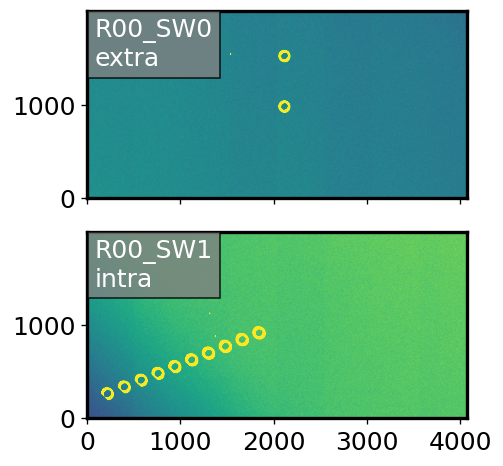

In [19]:
zscale = ZScaleInterval()

if sensor[1] == sensor[2]:
    ncols=1; nrows=2
else:
    ncols=2; nrows=1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4, 4), sharex=True, sharey=True, dpi=120)

# intra is more vignetted
if sensor[1] == "4":
    ax = ax[::-1]

# plot the extrafocal chip
i=0
for exposure, label in zip([extraImage, intraImage], ['extra','intra']):
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin,vmax=vmax,origin="lower")
    ax[i].text(0.02, 0.96, f"{ exposure.getInfo().getDetector().getName()}\n{label}", 
    transform=ax[i].transAxes, ha="left", va="top", c="w",fontsize=15,
             bbox=dict(facecolor='grey', alpha=0.8, edgecolor='black'))
    i=1


plt.tight_layout()
plt.show()

There are multiple intra-focal donut stamps, and only two extra-focal stamps. In normal operation of the `CloseLoopTask`, only two intra-focal donuts would get paired up with the two extra-focal donuts. In this experiment we pair up all intra-focal donuts with the central extra-focal donut. We vary the position first of extra, then intra-focal donut in each pair. This means that if we call  extra-focal donuts e0, e1, and  intra-focal donuts i0, i1, i2 ..., we have pairs  (e0,i0),  (e0,i1),  (e0,i2), ... (e0, iN).  

### Vary mask offset on a square grid:

In [ ]:
# Use the function above with different repo_dir
repo_name = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
offset_centroid_square_grid(repo_name, collection='ts_phosim_9006000', 
                            index_increase='intra',
                            experiment_index=3
                           )

Plot of the results:

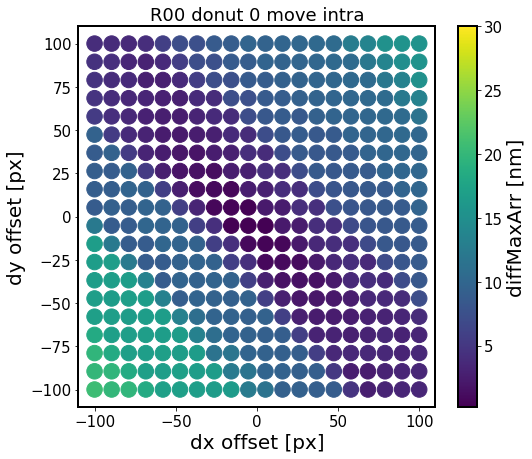

In [37]:
# read the data
sensor = 'R00'
defocal = 'intra'
i = 0
fname = f'{sensor}_donut_0_{i}_move_{defocal}_results_square_grid.npy'
results = np.load(fname, allow_pickle=True).item()

# convert to continuous arrays
diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPxArr.append(results[j]['dxPx'])
    dyPxArr.append(results[j]['dyPx'])
    diffMaxArr.append(results[j]['diffMax'])
    diffRmsArr.append(results[j]['diffRms'])

    

fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(np.array(dxPxArr), np.array(dyPxArr), c=diffMaxArr, s=240,
               vmax=30)
#ax.hexbin(dxPxArr,dyPxArr,C=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}')
plt.colorbar(sc, label = 'diffMaxArr [nm]')

The results are similar as above. Quantify by varying mask offset only in the radial direction. 

### Vary mask offset only in radial direction

In [ ]:
def get_nx_ny(x,y,dr):
    ''' Obtain new x, new y coordinate, 
    shifted by dr along radial direction.
    '''
    tan = x / y # y cannot be 0 
    dx = dr * (1 + tan**2.0)**(-0.5)
    dy = dr * (tan**2.0 / (1 + tan**2.0))**(0.5)

    # this ensures we shift away or toward the focal plane,
    # depending on dr and which quadrant we are in 
    nx = x - np.sign(x)*dx
    ny = y - np.sign(y)*dy
    
    return nx, ny 

def offset_centroid_radially(repo_dir,
                             intrument='LSSTCam', 
                             collection='ts_phosim_9006000',
                             sensors=['R00'],
                             experiment_index=5,
                             drDegMin=-0.3,
                             drDegMax=0.3,
                             drPxMin=-50,
                             drPxMax=50,
                             nGrid=1000,
                             out_dir = 'DM-33104'
                             ):
    ''' Offset centroid only in radial direction
    
    Parameters:
    --------------
    drDegMin: float, radial offset away from the donut 
            centroid in degrees, in the direction away 
            from the focal plane
    drDegMax: float, radial offset away from the donut 
            centroid in degrees, in the direction towards 
            from the focal plane
    nGrid: int, size of the computational space spanned by 
            (drDegMin, drDegMax), with regular intervals
    
    '''

    #################################
    ### STEP 1 :  Load the stamps
    #################################
    for sensor in sensors:
        print(f'Fitting {sensor}')
        donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                              iterN=0, detector=f"{sensor}_SW0",
                                              dataset_type = 'donutStampsExtra', 
                                              collection=collection)

        donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                              iterN=0, detector=f"{sensor}_SW1",
                                              dataset_type = 'donutStampsIntra', 
                                              collection=collection)

        extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
        # get the pixel scale from exposure to convert from pixels to arcsec to degrees
        pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


        # Given pixel scale, convert drPxMin, drPxMax to degrees
        if drDegMin is None:
            drDegMin = (drPxMin * pixelScale) / 3600. 
            print('Converting px to deg using pixel scale')
            print(f'{drPxMin} px is {drDegMin} degrees')
        if drDegMax is None:
            drDegMax = (drPxMax * pixelScale) / 3600. 
            print('Converting px to deg using pixel scale')
            print(f'{drPxMax} px is {drDegMax} degrees')
        
        configDir = getConfigDir()
        instDir = os.path.join(configDir, "cwfs", "instData")
        algoDir = os.path.join(configDir, "cwfs", "algo")

        # now I follow parts of 
        # wfEsti = WfEstimator(instDir, algoDir)
        inst = Instrument(instDir)
        algo = Algorithm(algoDir)

        # now I get the camera type and defocal distance
        # as inside estimateZernikes()
        # instName gets specified in the config,
        # and does not get overridden for CWFS
        instName='lsst'    
        camType = getCamType(instName)
        defocalDisInMm = getDefocalDisInMm(instName)

        # now I follow parts of 
        # wfEsti.config 
        opticalModel = 'offAxis'
        sizeInPix = 160
        inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

        # choose the solver for the algorithm 
        solver = 'exp' # or fft
        debugLevel = 0 # 1 to 3 
        algo.config(solver, inst, debugLevel=debugLevel)

        centroidFindType = CentroidFindType.RandomWalk
        imgIntra = CompensableImage(centroidFindType=centroidFindType)
        imgExtra = CompensableImage(centroidFindType=centroidFindType)


        #######################################
        ### STEP 2 :  Loop over donut pairs 
        #######################################

        for i in range(len(donutStampsIntra)):
            donutExtra = donutStampsExtra[0]
            donutIntra = donutStampsIntra[i]
            print(f'\n Fitting sensor {sensor}, donutIntra {i}, donutExtra 0 ')

            fieldXYExtra = donutExtra.calcFieldXY()
            fieldXYIntra = donutIntra.calcFieldXY()

            #######################################
            ### STEP 2 A : fit baseline (no offset)
            #######################################

            camera = donutExtra.getCamera()
            detectorExtra = camera.get(donutExtra.detector_name)
            detectorIntra = camera.get(donutIntra.detector_name)

            # Rotate any sensors that are not lined up with the focal plane.
            eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
            eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

            # Now parts of wfEsti.setImg, which inherits .setImg 
            # method from CompensableImage
            imgExtra.setImg(fieldXYExtra,
                            DefocalType.Extra,
                            image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

            imgIntra.setImg(fieldXYIntra,
                            DefocalType.Intra,
                            image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

            # wfEsti.reset() inherits the .reset method of Algorithm.py: 
            algo.reset()

            # wfEsti.calWfsErr() after checking for image size 
            # (both need to be squares)
            # calls the Algorithm.py
            tol = 1e-3
            algo.runIt(imgIntra,imgExtra, opticalModel, tol=tol)
            zk_no_offset = algo.getZer4UpInNm()

            # store the compensable image, as well as the zernikes
            baseline = {}
            baseline['imgIntra'] = imgIntra
            baseline['imgExtra'] = imgExtra
            baseline['zks'] = zk_no_offset

            fname = f'exp-{experiment_index}_{sensor}_donut_{i}_no_offset_zk_radial.npy'
            fpath = os.path.join(out_dir, fname)
            np.save(fpath, baseline)
            print(f'\nSaved the baseline fit (as well as imgIntra, imgExtra) as {fpath}')


            #########################################################
            ### STEP 2 B : fit over a range of radial distances 
            #########################################################


            ## First applying change to the extra-focal mask, and then to the intra-focal mask

            for defocal in ['intra', 'extra']: # or extra 
                print(f'Shifting the centroid for {defocal}-donut in that pair ')
                
                fname = f'exp-{experiment_index}_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
                fpath = os.path.join(out_dir, fname)
                if os.path.exists(fpath):
                    print(f'Skipping {fpath}')
                    pass
                else:
                    zk0 = zk_no_offset
                    results = {}
                    j =0 
                    for drDeg in np.linspace(drDegMin,drDegMax, nGrid):

                        if defocal == 'intra':
                            xDeg, yDeg = fieldXYIntra

                        elif defocal == 'extra':
                            xDeg, yDeg = fieldXYIntra

                        xDegNew, yDegNew = get_nx_ny(xDeg, yDeg, drDeg )

                        dxDeg = xDegNew - xDeg # +ve in I, IV,  -ve in II, III
                        dyDeg = yDegNew - yDeg # +ve in I, II, -ve in III, IV

                        dxPx = dxDeg*3600 / pixelScale
                        dyPx = dyDeg*3600 / pixelScale 

                        drPx = drDeg*3600 / pixelScale 


                        results[j] = {'dxDeg': dxDeg,  'dxPx' : dxPx, 
                                          'dyDeg': dyDeg,  'dyPx' : dyPx, 
                                          'drDeg': drDeg,  'drPx' : drPx, 
                                          }
                        # do the fit 
                        if defocal == 'extra':
                            fieldXYExtraUpd = (fieldXYExtra[0]+dxDeg, fieldXYExtra[1]+dyDeg)
                            fieldXYIntraUpd = fieldXYIntra

                        elif defocal =='intra':
                            fieldXYExtraUpd = fieldXYExtra
                            fieldXYIntraUpd = (fieldXYIntra[0]+dxDeg, fieldXYIntra[1]+dyDeg)

                        imgExtra.setImg(fieldXYExtraUpd,
                                        DefocalType.Extra,
                                        image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

                        imgIntra.setImg(fieldXYIntraUpd,
                                        DefocalType.Intra,
                                        image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


                        # right after we set the image, the compensable image mask is empty - 
                        # it is only calculated in Algorithm.py, L694
                        maskScalingFactorLocal = 1
                        boundaryT = algo.getBoundaryThickness()
                        imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
                        imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)

                        # store the imgIntra, imgExtra before running the algorithm
                        results[j]['imgExtra0mp'] = imgExtra.getNonPaddedMask()
                        results[j]['imgIntra0mp'] = imgIntra.getNonPaddedMask()

                        results[j]['imgExtra0mc'] = imgExtra.getPaddedMask()
                        results[j]['imgIntra0mc'] = imgIntra.getPaddedMask()

                        results[j]['imgExtra0img'] = imgExtra.getImg()
                        results[j]['imgIntra0img'] = imgIntra.getImg()

                        # now wfEsti.reset() simply calls the same method in `Algorithm.py` : 
                        algo.reset()

                        # now wfEsti.calWfsErr() after checking for image size (both need to be squares)
                        # simply calls algo:
                        tol = 1e-3 # explicitly set the tolerance level ( this is default )
                        algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)
                        zk = algo.getZer4UpInNm()

                        # store imgIntra, imgExtra after running the algorithm
                        results[j]['imgExtra1mp'] = imgExtra.getNonPaddedMask()
                        results[j]['imgIntra1mp'] = imgIntra.getNonPaddedMask()

                        results[j]['imgExtra1mc'] = imgExtra.getPaddedMask()
                        results[j]['imgIntra1mc'] = imgIntra.getPaddedMask()

                        results[j]['imgExtra1img'] = imgExtra.getImg()
                        results[j]['imgIntra1img'] = imgIntra.getImg()

                        # calculate diffMax, diffRms
                        diffMax = np.max(np.abs(zk - zk0))
                        diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))

                        # store the results 
                        results[j]['diffMax'] = diffMax
                        results[j]['diffRms'] = diffRms
                        results[j]['zk'] = zk
                        results[j]['imgExtraFieldXY'] = imgExtra.getFieldXY()
                        results[j]['imgIntraFieldXY'] = imgIntra.getFieldXY()

                        # increase the grid counter 
                        j += 1 
                        print(j, dxPx, dyPx, drPx,  diffRms, )
                    print(f"saved {fpath}")
                    np.save(fpath, results)

In [ ]:
# run the fitting 
repo_name = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
offset_centroid_radially(repo_dir, experiment_index=5, drDegMin=-0.1, drDegMax=0.1, nGrid=500,
                        )

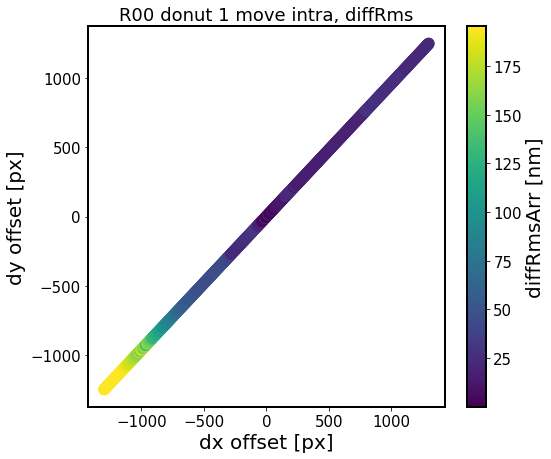

In [65]:
sensor = 'R00'
defocal = 'intra'
i = 1
experiment_index=5
out_dir = 'DM-33104'
fname = f'exp-{experiment_index}_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
fpath = os.path.join(out_dir, fname)
results = np.load(fpath, allow_pickle=True).item()


diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPx = results[j]['dxPx']
    dyPx = results[j]['dyPx'] 

    dxPxArr.append(dxPx)
    dyPxArr.append(dyPx)

    # calculate max difference and rms difference 
    # just like in test_multImgs.py for ts_wep 
    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)

# plot 
fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr,s=120)
#ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
plt.colorbar(sc, label = 'diffRmsArr [nm]')




Note, that for illustration this assumed unrealistically large offsets (+/- 4000 pixels), which is more than the size of the corner sensor. In reality, these offsets would not be more than a few ~tens of pixels at most. 

Below, for each donut we calculate the number of pixels in the mask different from the baseline mask, as well as N pixels  * image value. This is possible because at each stage we stored the compensable image 

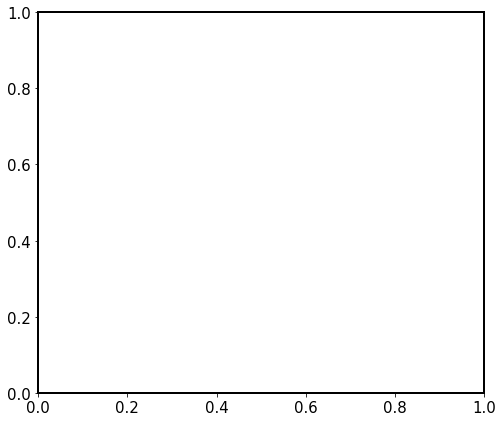

In [16]:
sensor = 'R00'

# read the baseline
i=1
experiment_index=5
out_dir = 'DM-33104'
fname = f'exp-{experiment_index}_{sensor}_donut_{i}_no_offset_zk_radial.npy'
fpath = os.path.join(out_dir, fname)

# read the results of shifting i-th intra/extra donut 
# plot 
fig,ax = plt.subplots(1,1,figsize=(8,7))
for defocal in ['intra','extra']:

    baseline =  np.load(fpath, allow_pickle=True).item()

In [17]:
baseline

{'imgIntra': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7f2130bfffa0>,
 'imgExtra': <lsst.ts.wep.cwfs.CompensableImage.CompensableImage at 0x7f2130bfffd0>,
 'zks': array([-5.07196063e+02,  9.78475446e+02,  6.23747193e+02,  8.49679525e+01,
         8.50545208e+01,  1.56190251e+02, -1.09767839e+02, -3.87802073e+00,
        -1.96655517e+01,  1.18376868e+01,  2.29286360e+01, -5.53952006e+01,
        -3.09483717e+01, -4.25239966e+01, -1.90701271e+01,  1.44933779e+01,
         3.69627187e-01, -4.87875259e+01,  7.05403974e+00])}

499
499
499
499
499
499
499
499


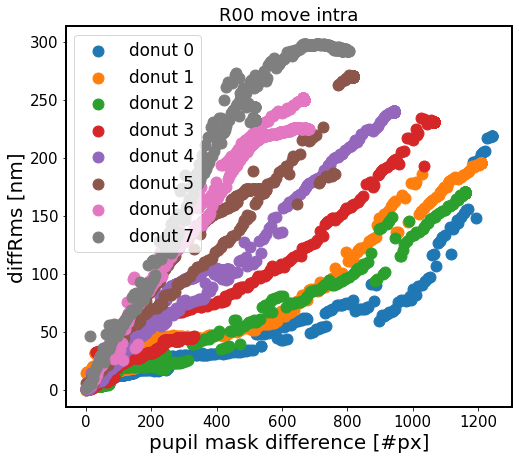

In [27]:
sensor = 'R00'

fig,ax = plt.subplots(1,1,figsize=(8,7))

# read the baseline
for i in range(8):
    experiment_index=5
    out_dir = 'DM-33104'
    fname = f'exp-{experiment_index}_{sensor}_donut_{i}_no_offset_zk_radial.npy'
    fpath = os.path.join(out_dir, fname)
    baseline =  np.load(fpath, allow_pickle=True).item()

    # read the results of shifting i-th intra/extra donut 
    # plot 
    
    for defocal in ['intra']:


        half = defocal.capitalize()

        mp0 = baseline[f'img{half}'].getNonPaddedMask()
        mc0 =  baseline[f'img{half}'].getPaddedMask()
        img0 = baseline[f'img{half}'].getImg()


        fname = f'exp-{experiment_index}_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
        fpath = os.path.join(out_dir, fname)
        results = np.load(fpath, allow_pickle=True).item()

        diffMaxArr = []
        diffRmsArr = []
        mcDiffArr = []
        mpDiffArr = []
        for j in results.keys():

            diffMax = results[j]['diffMax']
            diffRms = results[j]['diffRms']
            diffMaxArr.append(diffMax)
            diffRmsArr.append(diffRms)

            mp =  results[j][f'img{half}0mp']
            mc =  results[j][f'img{half}0mc']
            img = results[j][f'img{half}0img']

            # calculate mask difference 
            mcDiffArr.append(np.sum(mc-mc0))
            mpDiffArr.append(np.sum(mp-mp0))
        print(j)
        sc = ax.scatter(np.abs(mpDiffArr), diffRmsArr , s=120, label=f'donut {i}')

#ax.set_xlim(200,650)
#ax.set_ylim(80,120)

ax.set_xlabel('pupil mask difference [#px]')
ax.set_ylabel('diffRms [nm]')
ax.set_title(f'{sensor} move {defocal}')
ax.legend(fontsize=17)


In the above we shift the intra-focal donut centroid, keeping the extra-focal donut centroid unchanged. Each color represents a different donut. Donuts with increasing id are progressively further away from the center of the focal plane, which means that they react more strongly to smaller change in mask pixels.



Below we calculate the results radially on a much finer grid, and plot the summary results of diffRms vs pupil mask difference [px] for all donuts

In [ ]:
offset_centroid_radially(repo_dir,
                         experiment_index=6,
                         drDegMin=None,
                         drDegMax=None,
                         drPxMin=-50,
                         drPxMax=50,
                         nGrid=100)

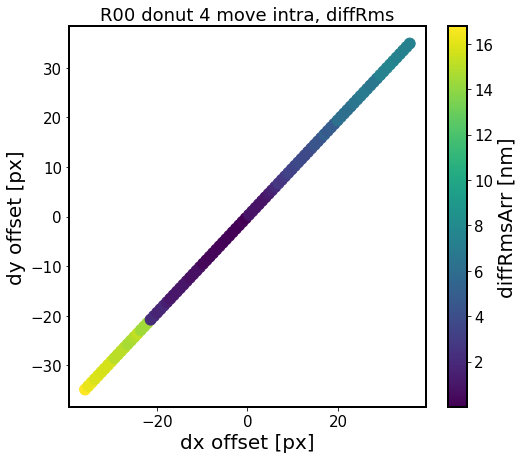

In [27]:
sensor = 'R00'
defocal = 'intra'
i = 4 
fname = f'exp-6_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
fpath = os.path.join('DM-33104',fname)
#fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle_finer.npy'
results = np.load(fpath, allow_pickle=True).item()


diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPx = results[j]['dxPx']
    dyPx = results[j]['dyPx'] 

    dxPxArr.append(dxPx)
    dyPxArr.append(dyPx)

    # calculate max difference and rms difference 
    # just like in test_multImgs.py for ts_wep 
    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)



# plot 
fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr,s=120)
#ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
plt.colorbar(sc, label = 'diffRmsArr [nm]')




Text(0.5, 1.0, 'R00 donut 4 move intra')

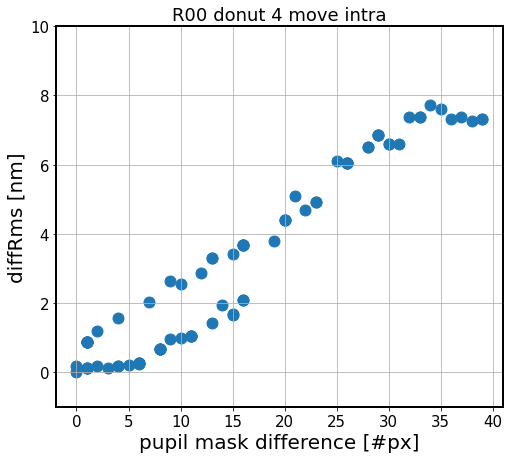

In [41]:
sensor = 'R00'

# read the baseline
fname_base = f'exp-6_{sensor}_donut_{i}_no_offset_zk_radial.npy'
fpath_base = os.path.join('DM-33104',fname_base)
baseline =  np.load(fpath_base, allow_pickle=True).item()
half = defocal.capitalize()

mp0 = baseline[f'img{half}'].getNonPaddedMask()
mc0 =  baseline[f'img{half}'].getPaddedMask()
img0 = baseline[f'img{half}'].getImg()

# read the results of shifting i-th intra/extra donut 
diffMaxArr = []
diffRmsArr = []
mcDiffArr = []
mpDiffArr = []

i=4
defocal='intra'
fname = f'exp-6_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
fpath = os.path.join('DM-33104',fname)
results = np.load(fpath, allow_pickle=True).item()

for j in results.keys():

    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)

    mp =  results[j][f'img{half}0mp']
    mc =  results[j][f'img{half}0mc']
    img = results[j][f'img{half}0img']

    # calculate mask difference 
    mcDiffArr.append(np.sum(mc-mc0))
    mpDiffArr.append(np.sum(mp-mp0))

# plot 
fig,ax = plt.subplots(1,1,figsize=(8,7))
#N = 100
sc = ax.scatter(np.abs(mpDiffArr), diffRmsArr , s=120)
ax.set_ylim(-1,10)
ax.grid()
ax.set_xlabel('pupil mask difference [#px]')
ax.set_ylabel('diffRms [nm]')
ax.set_title(f'{sensor} donut {i} move {defocal}')

As above, but on a smaller scale. Here shifts are  +/- 50 px.  

### Vary the mask offset in a circle 

In [ ]:
# run the fitting
offset_centroid_circle(repo_dir ,
    instrument = 'LSSTCam',
    collection='ts_phosim_9006000',
    sensors=['R00'],
    index_increase='intra', 
    experiment_index = 4)

Plot the results:

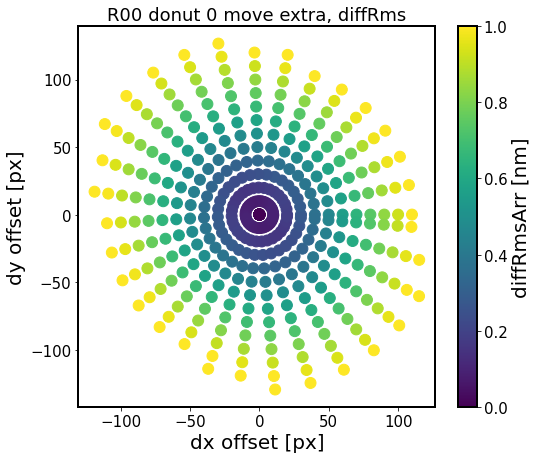

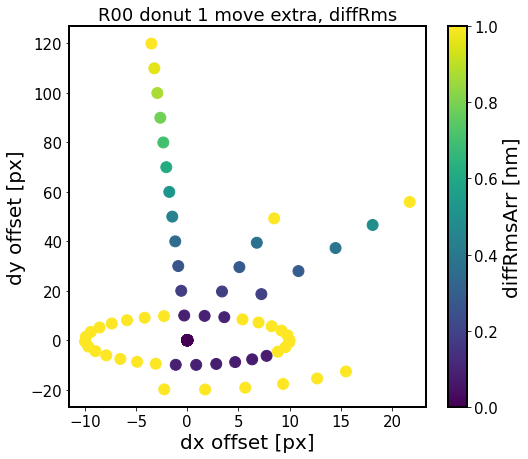

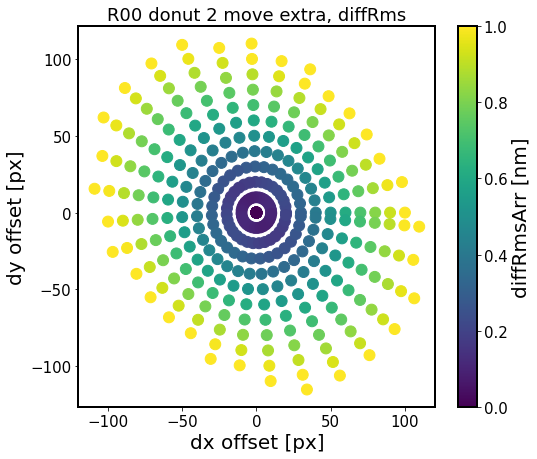

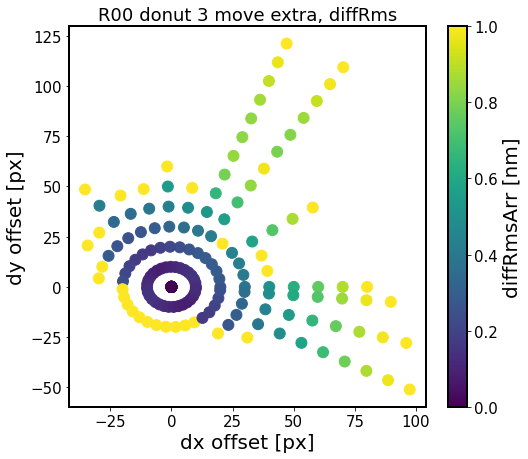

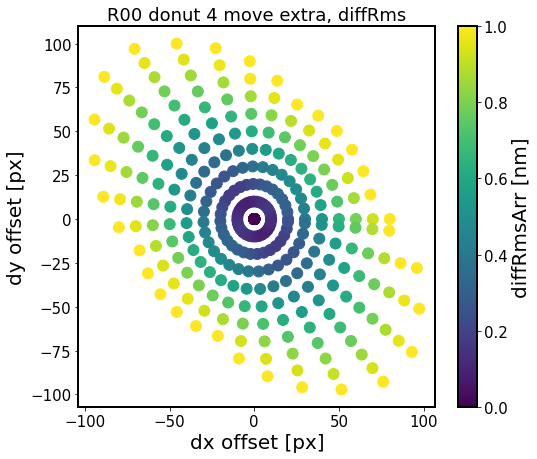

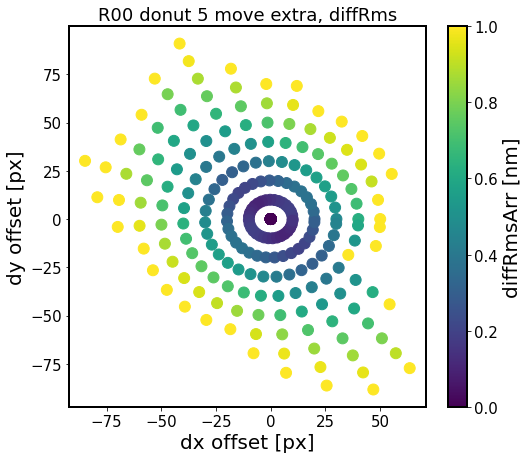

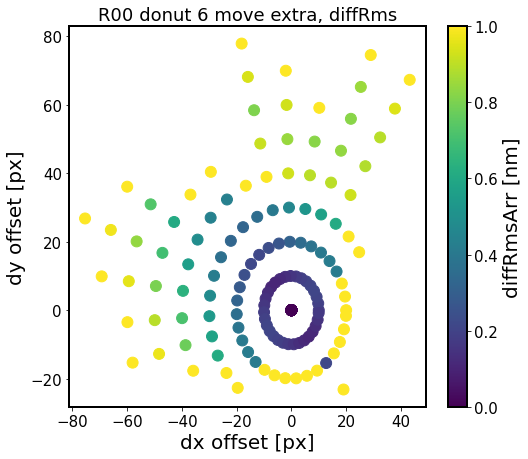

In [42]:
sensor = 'R00'
for i in range(7):
    defocal = 'extra'
    fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle.npy'
    #fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle_finer.npy'
    results = np.load(fname, allow_pickle=True).item()


    diffMaxArr = []
    diffRmsArr = []
    dxPxArr = []
    dyPxArr = []

    # convert the dx, dy in degrees to pixels 
    for j in results.keys():
        dxPx = results[j]['dxPx']
        dyPx = results[j]['dyPx'] 

        dxPxArr.append(dxPx)
        dyPxArr.append(dyPx)

        # calculate max difference and rms difference 
        # just like in test_multImgs.py for ts_wep 
        diffMax = results[j]['diffMax']
        diffRms = results[j]['diffRms']
        diffMaxArr.append(diffMax)
        diffRmsArr.append(diffRms)



    # plot 
    fig,ax = plt.subplots(1,1,figsize=(8,7))
    #N = 100
    sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr, vmax=1.,s=120)
    #ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
    ax.set_xlabel('dx offset [px]')
    ax.set_ylabel('dy offset [px]')
    ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
    plt.colorbar(sc, label = 'diffRmsArr [nm]')


